In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import adjusted_rand_score, silhouette_score

from src import akeneo, akeneo_clustering as ac, clustering, config

In [2]:
cache = akeneo.create_cache_from_env()

In [3]:
data_dir = config.dir_data / "clustering-results" / "2-phones"
data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
family = "smartphones"
channel = "default"
lang = "en_US"

In [5]:
products = ac.parse_products(
    cache,
    product_families=[family],
    attribute_types=ac.TYPES_NUMERICAL + ac.TYPES_CATEGORICAL + ac.TYPES_MULTI + ac.TYPES_TEXT,
)
products_multi_as_single = ac.transform_multi_to_single_cat(products)

products_df = pd.DataFrame(products)
products_multi_as_single_df = pd.DataFrame(products_multi_as_single)

In [6]:
labels_want_generations = products_df["__categories__"].map(lambda x: x[-1].split("_")[0]).to_numpy()
k_generations = len(set(labels_want_generations))
pd.Series(labels_want_generations).value_counts(), f"k = {k_generations}"

(s21    21
 s20    17
 s22     4
 dtype: int64,
 'k = 3')

In [7]:
labels_want_models = products_df["__categories__"].map(lambda x: x[-1]).to_numpy()
k_models = len(set(labels_want_models))
pd.Series(labels_want_models).value_counts(), f"k = {k_models}"

(s21          7
 s21_ultra    6
 s20          5
 s20_plus     5
 s20_ultra    4
 s21_plus     4
 s21_fe       4
 s20_fe       3
 s22          2
 s22_plus     1
 s22_ultra    1
 dtype: int64,
 'k = 11')

In [8]:
duplicates: dict[str, list[int]] = {}
for index, categories in products_df.to_dict()[ac.KEY_CATEGORIES].items():
    category = categories[0]
    if category[:4] != "dup_":
        continue

    if category not in duplicates:
        duplicates[category] = []
    duplicates[category].append(index)
duplicates

{'dup_s20': [1, 2],
 'dup_s20_ultra': [9, 10],
 'dup_s21_128': [18, 19],
 'dup_s21_256': [20, 21],
 'dup_s21_plus': [24, 25],
 'dup_s21_ultra': [32, 33]}

In [9]:
attr_metrics = {
    "code": [],
    "name": [],
    "type": [],
    "typeclass": [],
    "required": [],
    "non-null": [],
    "unique": [],
}

req_attr = list(filter(lambda f: f.code == family, cache.families))[0].attribute_requirements[channel]

for attr_code, attr in akeneo.Attribute.to_dict(cache.attributes).items():
    if attr_code not in products_df.columns:
        continue

    typeclass = (
        "numerical"
        if attr.type in ac.TYPES_NUMERICAL
        else "categorical"
        if attr.type in ac.TYPES_CATEGORICAL
        else "multi"
        if attr.type in ac.TYPES_MULTI
        else "string"
        if attr.type in ac.TYPES_TEXT
        else "unknown"
    )

    attr_metrics["code"].append(attr_code)
    attr_metrics["name"].append(attr.labels[lang])
    attr_metrics["type"].append(attr.type)
    attr_metrics["typeclass"].append(typeclass)
    attr_metrics["required"].append(attr_code in req_attr)
    attr_metrics["non-null"].append(products_df[attr_code].count())
    attr_metrics["unique"].append(products_df[attr_code].drop_duplicates().count())

attr_df = pd.DataFrame(attr_metrics)
attr_df.sort_values(["required", "non-null"], ascending=[False, False])

,code,name,type,typeclass,required,non-null,unique
10,icecat_12435_fixed,Rear camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,4
11,icecat_12437_fixed,Front camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,3
25,icecat_1585,Display resolution,AttributeType.TEXT,string,True,42,4
37,icecat_1766_fixed,Product color,AttributeType.SELECT_MULTI,multi,True,42,15
64,icecat_27587,Rear camera type,AttributeType.SELECT_SINGLE,categorical,True,42,2
...,...,...,...,...,...,...,...
108,icecat_3807,Package height,AttributeType.METRIC,numerical,False,1,1
109,icecat_3808,Package width,AttributeType.METRIC,numerical,False,1,1
112,icecat_38332,Heart rate sensor,AttributeType.BOOL,categorical,False,1,1
137,icecat_4857,Battery weight,AttributeType.METRIC,numerical,False,1,1


In [10]:
def _calc_duplicates_match(labels) -> float:
    result = 0.0
    n_duplicates = 0
    for _, indexes in duplicates.items():
        y1 = labels[indexes[0]]
        y2 = labels[indexes[1]]

        shared_clusters = len(y1.intersection(y2))
        all_clusters = len(y1.union(y2))

        result += (shared_clusters+1) / all_clusters
        n_duplicates += 1
    
    return result / n_duplicates

def calc_metrics(attr_codes, multi_as_single=False, attr_to_overweight: list[str] = None, factor = 2):
    dataset = (
        ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
        if not multi_as_single
        else ac.dataset_from_records(products_multi_as_single_df[attr_codes].to_dict("records"))
    )
    prox_matrix = ac.calc_proximity_matrix(dataset)

    if attr_to_overweight is not None:
        dataset = ac.overweight_attributes(dataset, attr_to_overweight, factor)

    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    biks = [
        clustering.BisectingKMeans(dataset, ac.Centroid, random_state=i)
        for i in range(1, 11)
    ]

    stabilities = []
    for k in range(2, len(dataset) + 1):
        values = []
        for bikk in biks:
            values.append(
                adjusted_rand_score(
                    bik.labels_flat(k),
                    bikk.labels_flat(k),
                )
            )
        stabilities.append(np.array(values).mean())
    stabilities = np.array(stabilities)

    qualities = []
    for k in range(2, len(dataset)):
        qualities.append(silhouette_score(prox_matrix, bik.labels_flat(k), metric="precomputed"))
    qualities = np.array(qualities)

    return {
        "stabilities": stabilities,
        "qualities": qualities,
        "match_gen": adjusted_rand_score(labels_want_generations, bik.labels_flat(k_generations)),
        "match_mod": adjusted_rand_score(labels_want_models, bik.labels_flat(k_models)),
        "match_dup": _calc_duplicates_match(bik.labels)
    }

In [11]:
def metrics_to_table(metric):
    result = {
        "Stability": metric["stabilities"].mean(),
        "Quality": metric["qualities"].mean(),
        "Match Generations": metric["match_gen"],
        "Match Models": metric["match_mod"],
        "Match Duplicates": metric["match_dup"],
    }
    result["Mean"] = np.array(list(result.values())).mean()
    return result

In [12]:
def attr_metrics_make():
    attr_metrics = {}
    for attr_code in attr_df["code"].to_list():
        m = calc_metrics([attr_code])
        attr_metrics[attr_code] = metrics_to_table(m)
    return attr_metrics
attr_metrics = config.load_or_create(data_dir / "attr-metrics.pkl", attr_metrics_make)

In [13]:
attr_metrics_df = pd.DataFrame(attr_metrics).transpose()
attr_metrics_df = attr_metrics_df.round(2) * 100
attr_metrics_df = pd.merge(attr_df, attr_metrics_df.reset_index().rename({"index": "code"}, axis=1), on="code")
attr_metrics_df.sort_values("Mean", ascending=False)

,code,name,type,typeclass,required,non-null,unique,Stability,Quality,Match Generations,Match Models,Match Duplicates,Mean
13,icecat_13246_fixed,Pixel density,AttributeType.NUMBER,numerical,False,37,11,94.0,56.0,15.0,74.0,89.0,66.0
184,icecat_94,Weight,AttributeType.METRIC,numerical,True,40,11,88.0,53.0,-1.0,87.0,89.0,63.0
101,icecat_36917,Second rear camera field of view (FOV) angle,AttributeType.METRIC,numerical,False,31,5,71.0,40.0,65.0,46.0,82.0,61.0
194,icecat_title,Title,AttributeType.TEXT,string,True,42,38,92.0,29.0,28.0,56.0,96.0,60.0
191,icecat_description_short,Short Description,AttributeType.TEXT,string,True,36,16,79.0,49.0,11.0,71.0,87.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,icecat_771_fixed,Form factor,AttributeType.SELECT_SINGLE,categorical,True,42,1,4.0,0.0,4.0,3.0,67.0,15.0
89,icecat_3577,Fingerprint reader,AttributeType.BOOL,categorical,False,42,1,4.0,0.0,4.0,3.0,67.0,15.0
139,icecat_4963,Touchscreen,AttributeType.BOOL,categorical,True,42,1,4.0,0.0,4.0,3.0,67.0,15.0
70,icecat_27603,Wireless video playback time,AttributeType.METRIC,numerical,False,1,1,5.0,-9.0,4.0,3.0,67.0,14.0


In [14]:
attr_metrics_df[
    (attr_metrics_df["Mean"] >= 60) |
    (attr_metrics_df["Match Generations"] >= 70) |
    (attr_metrics_df["Match Models"] >= 70) |
    (attr_metrics_df["Match Duplicates"] >= 90)
].sort_values("Mean", ascending=False)

,code,name,type,typeclass,required,non-null,unique,Stability,Quality,Match Generations,Match Models,Match Duplicates,Mean
13,icecat_13246_fixed,Pixel density,AttributeType.NUMBER,numerical,False,37,11,94.0,56.0,15.0,74.0,89.0,66.0
184,icecat_94,Weight,AttributeType.METRIC,numerical,True,40,11,88.0,53.0,-1.0,87.0,89.0,63.0
101,icecat_36917,Second rear camera field of view (FOV) angle,AttributeType.METRIC,numerical,False,31,5,71.0,40.0,65.0,46.0,82.0,61.0
194,icecat_title,Title,AttributeType.TEXT,string,True,42,38,92.0,29.0,28.0,56.0,96.0,60.0
191,icecat_description_short,Short Description,AttributeType.TEXT,string,True,36,16,79.0,49.0,11.0,71.0,87.0,59.0
5,icecat_11417,Native aspect ratio,AttributeType.SELECT_SINGLE,categorical,False,19,3,60.0,29.0,89.0,24.0,75.0,55.0
193,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,42,38,94.0,29.0,-3.0,58.0,97.0,55.0
147,icecat_7021,Maximum memory card size,AttributeType.METRIC,numerical,False,16,1,34.0,26.0,75.0,15.0,69.0,44.0


In [15]:
attr_codes_impact = [
    "icecat_13246_fixed",
    "icecat_94",
    "icecat_36917",
    "icecat_title",
    "icecat_description_short",
    "icecat_11417",
    "icecat_summary_short",
    "icecat_7021",
]

In [16]:
attr_codes_intuitive = [
    "icecat_13246_fixed",
    "icecat_944",
    "icecat_1464",
    "icecat_1649",
    "icecat_1650",
    "icecat_36912_fixed",
    "icecat_36910_fixed",
    "icecat_12437_fixed",
    "icecat_12435_fixed",
    "icecat_title",
    "icecat_brand",
    "icecat_3233",
    "icecat_40629",
    "icecat_75_fixed",
]
attr_codes_intuitive_plus = attr_codes_intuitive + [
    "icecat_94",
    "icecat_11379",
    "icecat_909",
    "icecat_1389_fixed",
    "icecat_8367_fixed",
    "icecat_16923_fixed",
    "icecat_14695_fixed",
    "icecat_42369_fixed",
    "icecat_432_fixed",
    "icecat_47",
    "icecat_6089",
    "icecat_1230",
]

### Eval Multi-Categorical

In [17]:
attr_df[(attr_df["typeclass"] == "multi")]

,code,name,type,typeclass,required,non-null,unique
14,icecat_13248_fixed,Social network services supported,AttributeType.SELECT_MULTI,multi,False,3,2
18,icecat_14695_fixed,4G bands supported,AttributeType.SELECT_MULTI,multi,False,8,7
19,icecat_1503_fixed,Modulation,AttributeType.SELECT_MULTI,multi,False,2,1
33,icecat_16923_fixed,3G standards,AttributeType.SELECT_MULTI,multi,True,40,4
35,icecat_1742_fixed,USB connector type,AttributeType.SELECT_MULTI,multi,False,40,1
37,icecat_1766_fixed,Product color,AttributeType.SELECT_MULTI,multi,True,42,15
44,icecat_1809_fixed,Voice codecs,AttributeType.SELECT_MULTI,multi,False,2,1
47,icecat_1830_fixed,Cables included,AttributeType.SELECT_MULTI,multi,False,37,2
56,icecat_2224_fixed,Audio formats supported,AttributeType.SELECT_MULTI,multi,False,38,7
74,icecat_2963_fixed,Resolution at capture speed,AttributeType.SELECT_MULTI,multi,False,37,5


In [18]:
attr_df[(attr_df["typeclass"] == "string")]

,code,name,type,typeclass,required,non-null,unique
9,icecat_12434,Rear camera resolution,AttributeType.TEXT,string,False,18,4
25,icecat_1585,Display resolution,AttributeType.TEXT,string,True,42,4
26,icecat_1597,Video capture resolution (max),AttributeType.TEXT,string,False,40,2
40,icecat_17956,Color name,AttributeType.TEXT,string,False,35,19
57,icecat_23731,Harmonized System (HS) code,AttributeType.TEXT,string,False,1,1
84,icecat_34,Contrast ratio (typical),AttributeType.TEXT,string,False,2,1
103,icecat_36920,Rear camera sensor size,AttributeType.TEXT,string,False,12,2
190,icecat_brand,Brand,AttributeType.TEXT,string,True,42,1
191,icecat_description_short,Short Description,AttributeType.TEXT,string,True,36,16
192,icecat_name,Name,AttributeType.TEXT,string,True,42,24


In [19]:
def mul_metrics_make():
    codes_mul = attr_df[(attr_df["typeclass"] == "multi")]["code"].to_list()
    codes_str = attr_df[(attr_df["typeclass"] == "string")]["code"].to_list()
    return {
        "multi": calc_metrics(codes_mul),
        "multi as single": calc_metrics(codes_mul, True),
        "string as multi": calc_metrics(codes_str),
        "string as single": calc_metrics(codes_str, True),
    }
mul_metrics = config.load_or_create(data_dir / "mul-metrics.pkl", mul_metrics_make)

,Stability,Quality,Match Generations,Match Models,Match Duplicates,Mean
multi,90.5,38.9,39.8,45.2,89.2,60.7
multi as single,85.4,38.5,11.7,30.0,87.8,50.7
string as multi,88.2,34.0,64.3,87.2,100.0,74.7
string as single,80.7,23.7,13.8,58.6,96.7,54.7


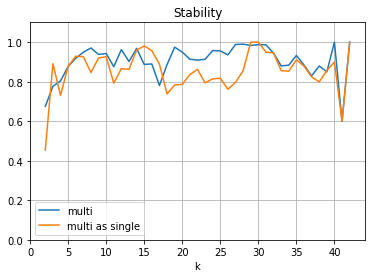

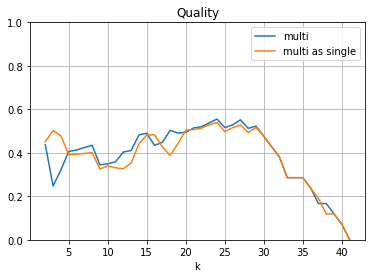

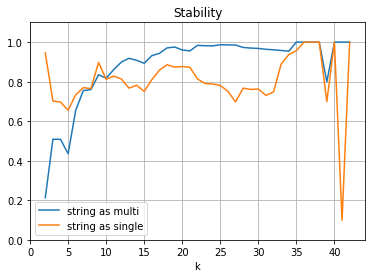

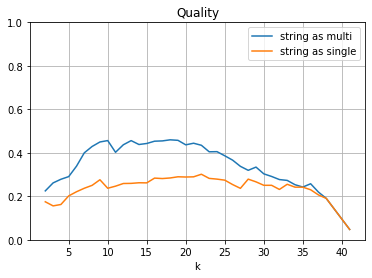

In [21]:
n = len(products)

pd.DataFrame({key: mul_metrics[key]["stabilities"] for key in ["multi", "multi as single"]}, index=range(2,n+1)).plot.line(title="Stability", xlabel="k", ylim=(0,1.1), grid=True)
pd.DataFrame({key: mul_metrics[key]["qualities"] for key in ["multi", "multi as single"]}, index=range(2,n)).plot.line(title="Quality", xlabel="k", ylim=(0,1), grid=True)

pd.DataFrame({key: mul_metrics[key]["stabilities"] for key in ["string as multi", "string as single"]}, index=range(2,n+1)).plot.line(title="Stability", xlabel="k", ylim=(0,1.1), grid=True)
pd.DataFrame({key: mul_metrics[key]["qualities"] for key in ["string as multi", "string as single"]}, index=range(2,n)).plot.line(title="Quality", xlabel="k", ylim=(0,1), grid=True)

pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in mul_metrics.items()
}).transpose().round(3) * 100

In [21]:
case_to_attr = {
    "numerical": attr_df[attr_df["typeclass"]=="numerical"]["code"].to_list(),
    "categorical": attr_df[attr_df["typeclass"]=="categorical"]["code"].to_list(),
    "multi": attr_df[attr_df["typeclass"]=="multi"]["code"].to_list(),
    "string": attr_df[attr_df["typeclass"]=="string"]["code"].to_list(),
    "num+cat": attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])]["code"].to_list(),
    "num+cat+mul": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi"])]["code"].to_list(),
    "num+cat+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "string"])]["code"].to_list(),
    "num+cat+mul+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])]["code"].to_list(),
    "numerical req": attr_df[(attr_df["typeclass"]=="numerical")&attr_df["required"]]["code"].to_list(),
    "categorical req": attr_df[(attr_df["typeclass"]=="categorical")&attr_df["required"]]["code"].to_list(),
    "num+cat req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])&attr_df["required"]]["code"].to_list(),
    "num+cat+mul req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi"])&attr_df["required"]]["code"].to_list(),
    "num+cat+str req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "string"])&attr_df["required"]]["code"].to_list(),
    "num+cat+mul+str req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])&attr_df["required"]]["code"].to_list(),
}
pd.DataFrame([(key, value) for key, value in case_to_attr.items()])

,0,1
0,numerical,"[icecat_11379, icecat_12435_fixed, icecat_1243..."
1,categorical,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
2,multi,"[icecat_13248_fixed, icecat_14695_fixed, iceca..."
3,string,"[icecat_12434, icecat_1585, icecat_1597, iceca..."
4,num+cat,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
5,num+cat+mul,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
6,num+cat+str,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
7,num+cat+mul+str,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
8,numerical req,"[icecat_11379, icecat_12435_fixed, icecat_1243..."
9,categorical req,"[icecat_16922, icecat_19653, icecat_2183, icec..."


In [22]:
def metrics_make():
    metrics = {
        key: calc_metrics(value)
        for key, value in case_to_attr.items()
    }

    all_codes = attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])]["code"].to_list()
    codes_num_cat = attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])]["code"].to_list()
    codes_str = attr_df[attr_df["typeclass"].isin(["string"])]["code"].to_list()

    return {
        **metrics,
        "high impact": calc_metrics(attr_codes_impact),
        "all & high impact x2": calc_metrics(all_codes, False, attr_codes_impact, 2),
        "all & high impact x3": calc_metrics(all_codes, False, attr_codes_impact, 3),
        "num+cat & high impact x2": calc_metrics(codes_num_cat, False, attr_codes_impact, 2),
        "num+cat & high impact x3": calc_metrics(codes_num_cat, False, attr_codes_impact, 3),
        "str & high impact x2": calc_metrics(codes_str, False, attr_codes_impact, 2),
        "str & high impact x3": calc_metrics(codes_str, False, attr_codes_impact, 3),
        "intuitive": calc_metrics(attr_codes_intuitive),
        "all & intuitive x2": calc_metrics(all_codes, False, attr_codes_intuitive, 2),
        "all & intuitive x3": calc_metrics(all_codes, False, attr_codes_intuitive, 3),
        "num+cat & intuitive x2": calc_metrics(codes_num_cat, False, attr_codes_intuitive, 2),
        "num+cat & intuitive x3": calc_metrics(codes_num_cat, False, attr_codes_intuitive, 3),
        "str & intuitive x2": calc_metrics(codes_str, False, attr_codes_intuitive, 2),
        "str & intuitive x3": calc_metrics(codes_str, False, attr_codes_intuitive, 3),
        "intuitive+": calc_metrics(attr_codes_intuitive_plus),
        "all & intuitive+ x2": calc_metrics(all_codes, False, attr_codes_intuitive_plus, 2),
        "all & intuitive+ x3": calc_metrics(all_codes, False, attr_codes_intuitive_plus, 3),
        "num+cat & intuitive+ x2": calc_metrics(codes_num_cat, False, attr_codes_intuitive_plus, 2),
        "num+cat & intuitive+ x3": calc_metrics(codes_num_cat, False, attr_codes_intuitive_plus, 3),
        "str & intuitive+ x2": calc_metrics(codes_str, False, attr_codes_intuitive_plus, 2),
        "str & intuitive+ x3": calc_metrics(codes_str, False, attr_codes_intuitive_plus, 3),
    }

metrics = config.load_or_create(data_dir / "metrics.pkl", metrics_make)

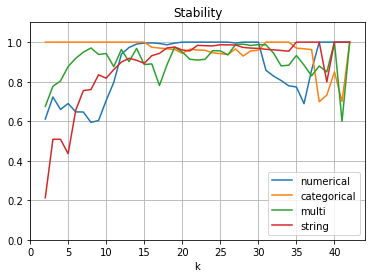

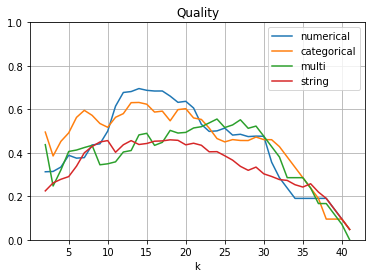

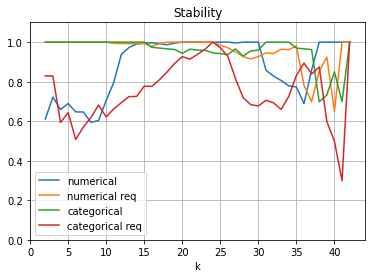

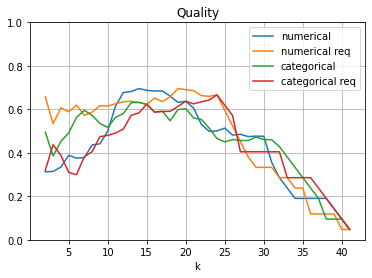

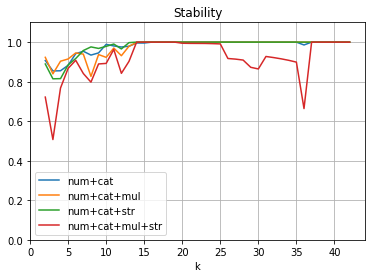

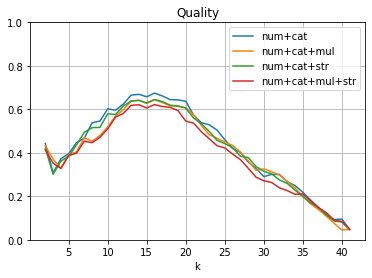

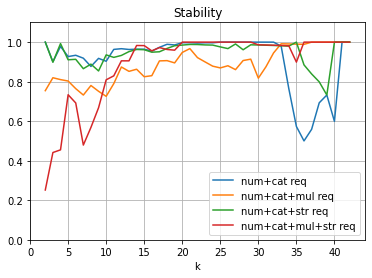

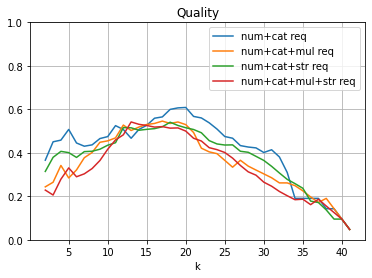

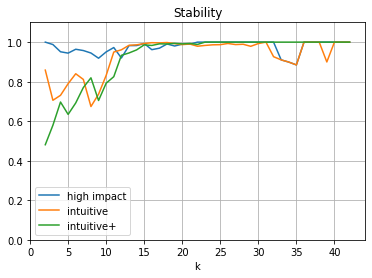

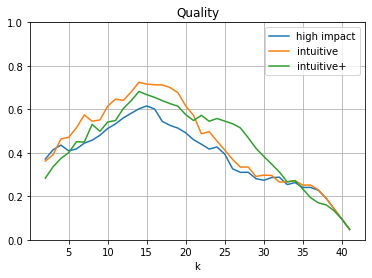

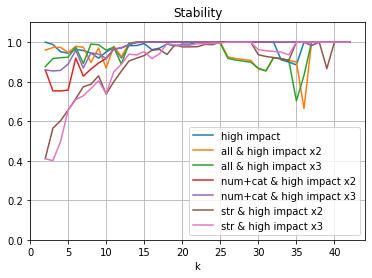

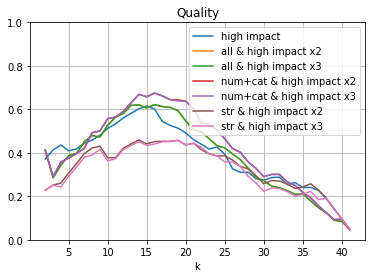

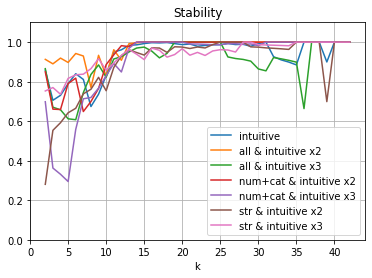

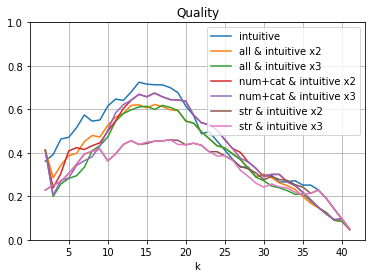

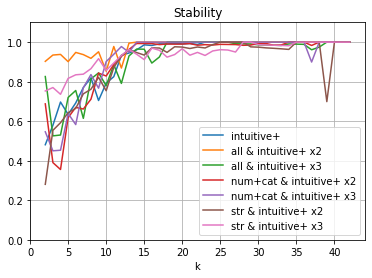

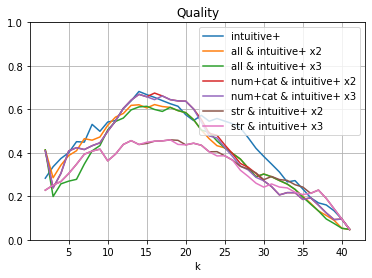

In [23]:
keys_display = [
    ["numerical", "categorical", "multi", "string"],
    ["numerical", "numerical req", "categorical", "categorical req"],
    ["num+cat", "num+cat+mul", "num+cat+str", "num+cat+mul+str"],
    ["num+cat req", "num+cat+mul req", "num+cat+str req", "num+cat+mul+str req"],
    ["high impact", "intuitive", "intuitive+"],
    ["high impact", "all & high impact x2", "all & high impact x3", 
     "num+cat & high impact x2", "num+cat & high impact x3",
     "str & high impact x2", "str & high impact x3"],
    ["intuitive", "all & intuitive x2", "all & intuitive x3", 
     "num+cat & intuitive x2", "num+cat & intuitive x3",
     "str & intuitive x2", "str & intuitive x3"],
    ["intuitive+", "all & intuitive+ x2", "all & intuitive+ x3",
     "num+cat & intuitive+ x2", "num+cat & intuitive+ x3",
     "str & intuitive+ x2", "str & intuitive+ x3"],
]
for keys in keys_display:
    stabs = {key: metrics[key]["stabilities"] for key in keys}
    quals = {key: metrics[key]["qualities"] for key in keys}
    pd.DataFrame(stabs, index=range(2,n+1)).plot.line(title="Stability", xlabel="k", ylim=(0,1.1), grid=True)
    pd.DataFrame(quals, index=range(2,n)).plot.line(title="Quality", xlabel="k", ylim=(0,1), grid=True)

In [24]:
metrics_df = pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics.items()
}).transpose()

In [25]:
metrics_df.sort_values("Mean", ascending=False).round(2) * 100

,Stability,Quality,Match Generations,Match Models,Match Duplicates,Mean
str & intuitive+ x3,94.0,33.0,70.0,85.0,100.0,76.0
str & intuitive x3,94.0,33.0,70.0,85.0,100.0,76.0
str & intuitive+ x2,90.0,33.0,70.0,85.0,100.0,76.0
str & intuitive x2,90.0,33.0,70.0,85.0,100.0,76.0
str & high impact x2,90.0,33.0,70.0,88.0,97.0,75.0
str & high impact x3,90.0,32.0,70.0,88.0,97.0,75.0
all & high impact x2,95.0,39.0,72.0,70.0,100.0,75.0
all & high impact x3,95.0,39.0,72.0,70.0,100.0,75.0
all & intuitive+ x2,98.0,39.0,72.0,70.0,96.0,75.0
string,88.0,34.0,64.0,87.0,100.0,75.0
